## U-Nets

### Background

Typical CNNs are used primarily for classification tasks, where the entirity of an image is mapped to a label or class. However, in many tasks such as **biomedical imaging tasks**, the desired output should be localised. In simple words, we want labels for local areas of the images; instead of the entirity of the image being mapped to a label, **we want each pixel to be mapped to a label.**

An example of segmentation can be seen below, where each pixel is identified to be of a class and labeled accordingly.

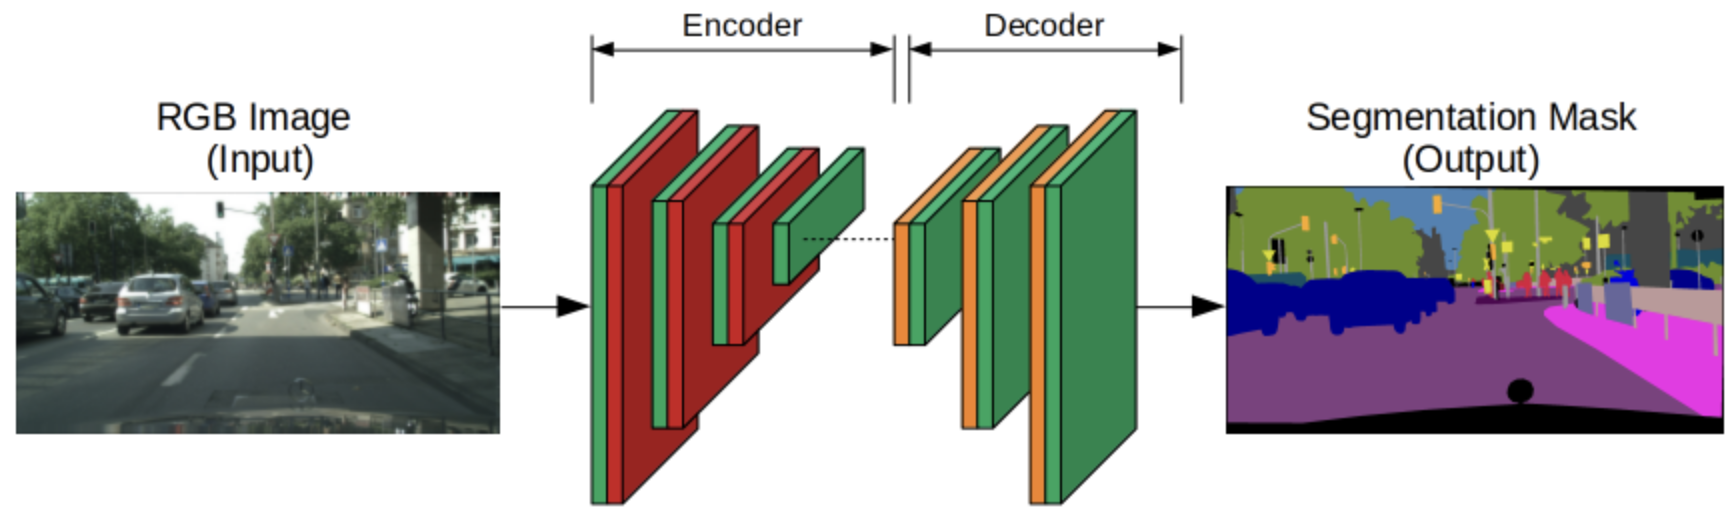

Ciresan et al. [1] has previously trained a network in a sliding-window setup to predict the class label of each pixel by providing a local region (patch) around that pixel as input. In simple words, for each pixel in an input image, a crop of the input image around the pixel was taken as context. This context patch was then passed into a CNN which predicted the label of the pixel.

> Could localise, but it is very slow as the network has to be run separately for each patch. In terms of training data, there is a a lot more training images resulting from 'patching' and a lot of redundancy due to overlapping patches.

> Finally, there is a trade-off b/w localisation accuracy and context, which referrs size of the patch inputted for output of one pixel. Larger patches require more max-pooling layers that reduce the localization accuracy, while small patches allow the network to see only little context.

### Max-Pooling

> Think of max pooling as a function $f(X)$ that takes an input region $X$ of size $n x n$ and outputs a single value - the maximum element in that region:
$$f(X) = max(x_{ij}); \;\; i , j \in [1,n]$$
This function slides across the input matrix with a defined stride s, progressively reducing the spatial dimensions while preserving the highest activation values.

In [27]:
# Input:           After Max Pool:
# 1  3  1  4         3  4
# 2  3  4  1    →    8  7
# 1  8  7  2
# 5  2  1  7

### Network Architecture: Downsampling Path

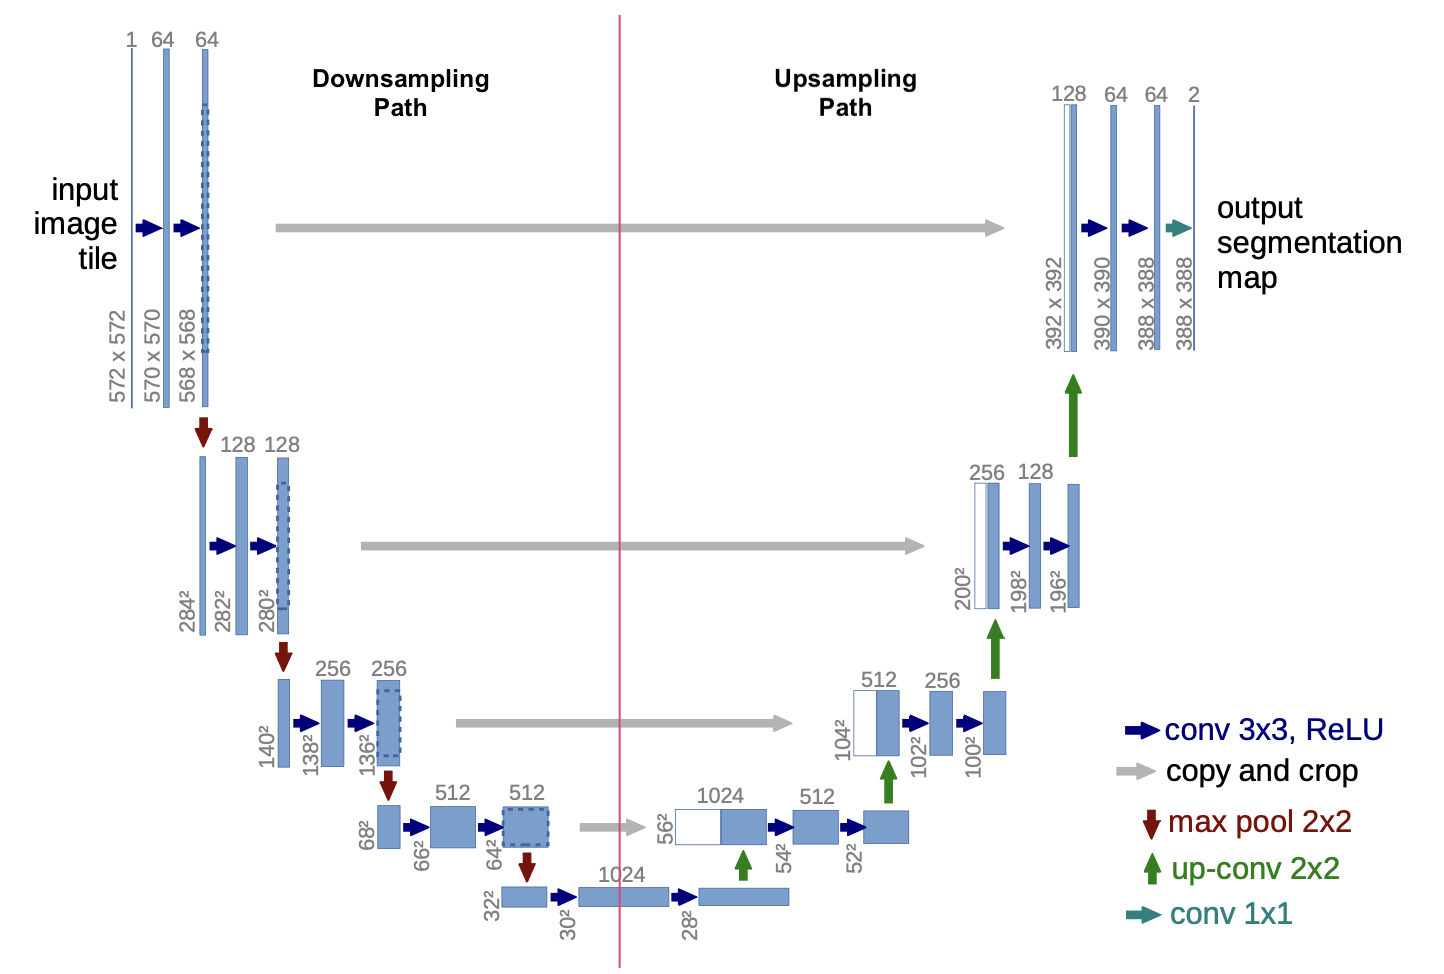

This is called the U-Net due to the shape of the architecture. It can be broken into two halves, the first half of the U, the encoder, and the second half, the decoder.

The encoder, or the Downsampling Path has 4 Convolutional Blocks. Each block has two Convolutional Layers (64 Kernels each, Kernel Size: 3 x 3, with ReLU activation) followed by Max Pooling (2 x 2 with stride 2), which reduces the dimensions to half. The second convoluional does the same, with 128 Kernels for each Convolutional Layer, which is then Max Pooled and passed into a third and fourth block, each with twice the number of Kernels as the previous layer.

Key features of the Downsamping Path is that it reduces resolution, and increases depth. All convolutions in this step have valid padding, or no padding with ReLU activations.

### Transverse Convolution or Up-Conv

This essentially "un-does" the effect of Max Pooling. A good resource to understand Transverse Convolution is this [video by Andrew Ng](https://www.youtube.com/watch?v=qb4nRoEAASA).

### Network Architecture: Downsampling -> Upsampling Path

This is the fifth Convolutional Block where the output of the fourht layer is MaxPooled to $32^2$ dimension, and then passed through one two last Downsampling Convolutional Layers of with 1024 Kernels reducing the dimension to $28^2$ with 1024 depth. From here on the Upsampling Path is symmetric to the Downsampling Path.

In each Convolution Block there are two layers, with half the number of Kernels as the previous Convolutional Block. Before being passed to the next convolutional block, it is up-sampled, i.e a sort of "reverse Max Pool" is applied using tranverse convolution which doubles the dimensions and halves the depth of the image. Furthermore this up-convoluted output is added to a cropped output from the corresponding Downsampling Layer, which adds up in depth.

Finally a 1 x 1 convolution is done, which converts the 388 x 388 with depth 64 to a single channel 388 x 388 image. Essentially all corresponding pixel values are added together from the 64 layers.

### Significance of Downsampling Path, Step Connections, and Upsampling Path

The downsampling (encoder) path of U-Net progressively reduces spatial dimensions while increasing feature channels, allowing each neuron to see a larger portion of the original image through an expanding receptive field. Starting with basic 3x3 convolutions that detect simple edges and textures, each pooling layer doubles the effective area each neuron can "see," enabling deeper layers to recognize increasingly complex patterns and broader contextual information. This hierarchical feature extraction is crucial for understanding semantic content in the image.

The upsampling (decoder) path gradually recovers spatial information while incorporating the semantic understanding gained from the deeper layers. Through up-convolutions, the network learns to reconstruct detailed spatial information, progressively increasing resolution while reducing feature channels. This enables the network to transform abstract, semantic understanding back into precise spatial localization.

The skip connections between corresponding encoder and decoder layers are vital for preserving and combining fine-grained spatial details with semantic understanding. By concatenating high-resolution features from the encoder path with upsampled features from the decoder path, the network can combine low-level details (like edges and textures) with high-level semantic information. This enables precise boundary detection while maintaining semantic context, which is essential for accurate image segmentation.

### Training

It is interesting to note that the input image dimensions are 572 x 572, while the output is only 388 x 388 due to the unpadded convolutions. Input images start off as 388 x 388, and the edges are 'expanded' using mirroring. Thus to predict the segmentation of an image of dimensions 388 x 388, we need to create context for the bordering pixels.

For example, in the following image, prediction of the segmentation in the yellow area, requires image data within the blue area as input. Missing input data is extrapolated by mirroring the actual image over the edge.

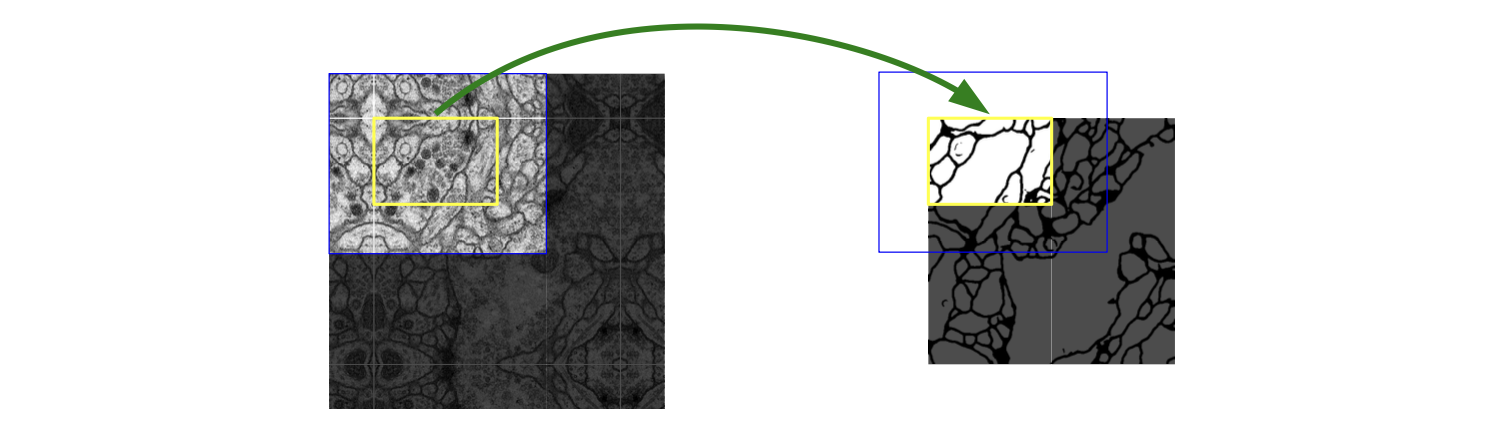

The model outputs a raw activations $a_k(x)$ in shape $(K × 388 × 388)$ where $K$ is the number of classes. Then a pixel wise softmax is applied to the whole image, the size is still $(K × 388 × 388)$ except the activations have been converted to probabilities.

$$p_k(x) = \frac{e^{ak(x)}}{\sum e^{ak'(x)}}$$

Next a weight map is created to take care of potential class imbalances. $w_c(x)$ is calculated as

$$w_c(x) = \frac{1}{class \; f \; of \; the \; pixel \; class \; at \; x}$$

This is used to create a weight map of shape $1 x 388 x 388$ using the following formula

$$w(x) = w_c(x) + w_0  e^{-(d_1(x) + d_2(x))^2/2\sigma^2}$$

Where $w_c(x)$: Balances class frequencies (addresses class imbalance); $d_1(x)$: Distance to nearest cell border; $d_2(x)$: Distance to second nearest cell border; $w_0$ = 10 (weight coefficient); $\sigma$ = 5 pixels (controls the width of border emphasis)

The loss funciton is

$$E = \sum w(x) log(p_{l(x)}(x))$$

Where $p_{l(x)}$ is the softmax probability of the correct class at that pixel. Finally, argmax is taken of the softmax values to result in a $1 x 388 x 388$ segmented image. In the original U-Net paper, K = 2.

## PyTorch Implementation of U-Net on the Carvana Image Masking Challenge Dataset

In [62]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
import glob

In [114]:
# Double Convolution

class DoubleConv(nn.Module):
  def __init__(self, input, output) -> None:
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(input, output, 3, 1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(output, output, 3, 1, padding=1),
        nn.ReLU(inplace=True)
    )

  def forward(self, x):
    return self.conv(x)

# Downsampling Path
class Downsample(nn.Module):
  def __init__(self, input, output) -> None:
    super().__init__()
    self.conv = DoubleConv(input, output)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

  def forward(self, x):
    dconv = self.conv(x)
    pool = self.pool(dconv)

    return dconv, pool

# Upsampling Path
class Upsampling(nn.Module):
  def __init__(self, input, output) -> None:
    super().__init__()
    self.up = nn.ConvTranspose2d(input, input//2, 2, 2)
    self.conv = DoubleConv(input, output)

  def forward(self, x1, x2):
    up = self.up(x1)

    # Calculate center crop dimensions
    diff_y = x2.size()[2] - up.size()[2]
    diff_x = x2.size()[3] - up.size()[3]
    
    x2 = x2[:, :, 
            diff_y//2:(diff_y//2 + up.size()[2]), 
            diff_x//2:(diff_x//2 + up.size()[3])]
    
    up = torch.concat([up, x2], 1)
    
    uconv = self.conv(up)

    return uconv


In [116]:
class UNet(nn.Module):
  def __init__(self, input, out): # input is the dimension, out is the number of classes
    super().__init__()

    # Downsampling Path
    self.down1 = Downsample(input, 64)
    self.down2 = Downsample(64, 128)
    self.down3 = Downsample(128, 256)
    self.down4 = Downsample(256, 512)

    # Down -> Upsampling neck
    self.toup = DoubleConv(512, 1024)

    # Upsampling Path
    self.up1 = Upsampling(1024, 512)
    self.up2 = Upsampling(512, 256)
    self.up3 = Upsampling(256, 128)
    self.up4 = Upsampling(128, 64)

    # Final Conv
    self.out = nn.Conv2d(64, out, 1)

  def forward(self, x):
    x1, p1 = self.down1(x)
    x2, p2 = self.down2(p1)
    x3, p3 = self.down3(p2)
    x4, p4 = self.down4(p3)

    b = self.toup(p4)

    x5 = self.up1(b, x4)
    x6 = self.up2(x5, x3)
    x7 = self.up3(x6, x2)
    x8 = self.up4(x7, x1)

    x9 = self.out(x8)

    return x9

In [166]:
model = UNet(3, 1)

In [167]:
# Check if MPS (Metal Performance Shaders) is available
device = torch.device("mps")

model.to(device)

UNet(
  (down1): Downsample(
    (conv): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down2): Downsample(
    (conv): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down3): Downsample(
    (conv): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      

In [168]:
# Image + Mask creation

def load(imfolder, maskfolder, batch_size):
  x_transform = transforms.Compose([
      transforms.Resize((256, 256)),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # For RGB images
  ])

  mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
  ])

  image_paths = sorted(glob.glob(f"{imfolder}/*"))
  mask_paths = sorted(glob.glob(f"{maskfolder}/*"))

  images, masks = [], []

  for image, mask in zip(image_paths, mask_paths):
    img = Image.open(image).convert('RGB')
    mask = Image.open(mask).convert('L')

    images.append(x_transform(img))
    masks.append(mask_transform(mask))

  images = torch.stack(images)
  masks = torch.stack(masks)

  # Create a dataset
  dataset = TensorDataset(images, masks)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

  return dataloader


In [169]:
training_loss = []

def train(model, dataloader, epochs=3, lr=0.0001):
  model = model.to(device)

  optimiser = torch.optim.Adam(model.parameters(), lr)
  loss_fn = nn.BCEWithLogitsLoss()

  for epoch in range(epochs):
    model.train()

    for b, (x, y) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)

        optimiser.zero_grad()

        ypred = model(x)
        loss = loss_fn(ypred, y)

        loss.backward()
        optimiser.step()
        
        if b % 10 == 0:
            training_loss.append(loss.item())
            print(f"Epoch: {epoch} \t Batch: {b} \t Loss: {loss.item()}")

In [170]:
train_loader = load(
    'train/',
    'train_masks/',
    batch_size=32
)

In [171]:
import time

start = time.time()

train_loss = train(model, train_loader, 1, 3e-4)

end = time.time()

print(f"Training time: {end - start}s")

Epoch: 0 	 Batch: 0 	 Loss: 0.6888059377670288
Epoch: 0 	 Batch: 10 	 Loss: 0.42865854501724243
Epoch: 0 	 Batch: 20 	 Loss: 0.3670629858970642
Epoch: 0 	 Batch: 30 	 Loss: 0.29910174012184143
Epoch: 0 	 Batch: 40 	 Loss: 0.23225665092468262
Epoch: 0 	 Batch: 50 	 Loss: 0.16684186458587646
Epoch: 0 	 Batch: 60 	 Loss: 0.1369066834449768
Epoch: 0 	 Batch: 70 	 Loss: 0.13284701108932495
Epoch: 0 	 Batch: 80 	 Loss: 0.14213043451309204
Epoch: 0 	 Batch: 90 	 Loss: 0.1150541827082634
Epoch: 0 	 Batch: 100 	 Loss: 0.10247024893760681
Epoch: 0 	 Batch: 110 	 Loss: 0.07805769145488739
Epoch: 0 	 Batch: 120 	 Loss: 0.0519152395427227
Epoch: 0 	 Batch: 130 	 Loss: 0.05354993790388107
Epoch: 0 	 Batch: 140 	 Loss: 0.04664473980665207
Epoch: 0 	 Batch: 150 	 Loss: 0.03820054233074188
Training time: 4167.383774995804s


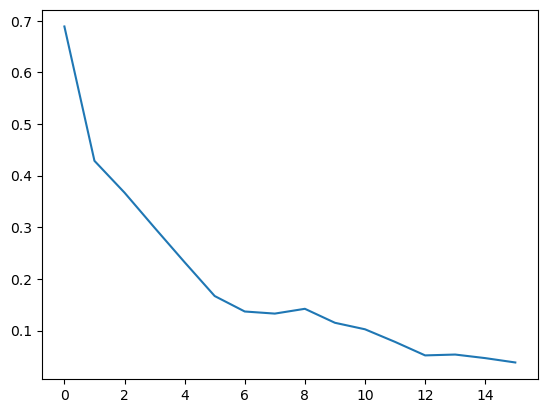

In [175]:
import matplotlib.pyplot as plt

plt.plot(training_loss)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.9764706].


(-0.5, 255.5, 255.5, -0.5)

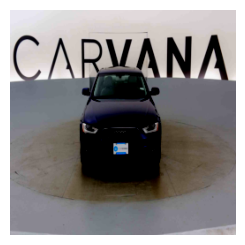

In [173]:
# The following image is used for testing; it was not a part of the training set
# Implementing validation set is recommended, however it was not done in training above
# due to the large amounf of time it takes to train

x_transform = transforms.Compose([
      transforms.Resize((256, 256)),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # For RGB images
  ])

mask_transform = transforms.Compose([
  transforms.Resize((256, 256)),
  transforms.ToTensor()
])

demo_img = Image.open('0cdf5b5d0ce1_01.jpg').convert('RGB')
demo_img = x_transform(demo_img)
demo_img = demo_img.permute(1, 2, 0)

plt.subplot(1, 2, 1)
plt.imshow(demo_img)
plt.axis('off') 

(-0.5, 255.5, 255.5, -0.5)

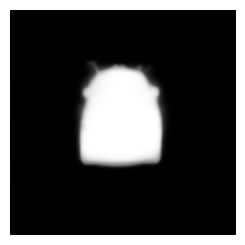

In [174]:
# Ensure input is in the right format (B, C, H, W)
demo_img = demo_img.unsqueeze(0)  # Add batch dimension if not present
if demo_img.shape[-1] == 3:  # If channels are last
    demo_img = demo_img.permute(0, 3, 1, 2)

segmented = model(demo_img.to(device))
segmented = torch.sigmoid(segmented)

plt.subplot(1, 2, 2)
plt.imshow(segmented.squeeze().detach().cpu(), cmap='gray')
plt.axis('off')

## References

[1] Ciresan, D.C., Gambardella, L.M., Giusti, A., Schmidhuber, J.: Deep neural net-works segment neuronal membranes in electron microscopy images. In: NIPS. pp.2852–2860 (2012)

[2] Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "U-net: Convolutional networks for biomedical image segmentation." Medical image computing and computer-assisted intervention–MICCAI 2015: 18th international conference, Munich, Germany, October 5-9, 2015, proceedings, part III 18. Springer International Publishing, 2015.